In [1]:
from gibbs import *
import numpy as np
import pystan
from data_pertub import *
from mcmc_plot import *
from PPCA_pystan import *
import warnings
from PPCA_pystan import *
warnings.filterwarnings("ignore")

##  1. Generate Data

In [2]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
data_config = dict(config['data_config'])

In [3]:
n_sample = int(data_config['n_sample'])
alpha = float(data_config['alpha'])


d = int(data_config['d'])
q_star = int(data_config['q_star'])
a_vj = float(data_config['a_vj']) * np.ones(q_star)
epsilon = float(data_config['epsilon'])
beta_vj = epsilon * (a_vj - 1)
beta_sigma2 = float(data_config['beta_sigma2'])
a_sigma2 = float(data_config['a_sigma2'])

prior_param_true = dict({'beta_sigma2': beta_sigma2,
                         'a_sigma2': a_sigma2,
                         'a_vj': a_vj,
                         'beta_vj': beta_vj
                         })

true sigma2_star is 0.09736745529582763
true v_j list is [4.05951563]


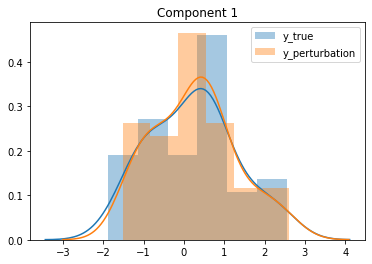

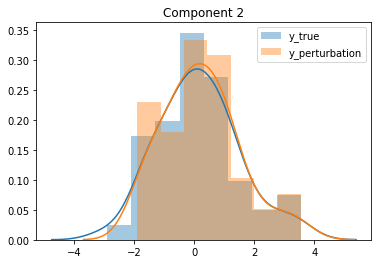

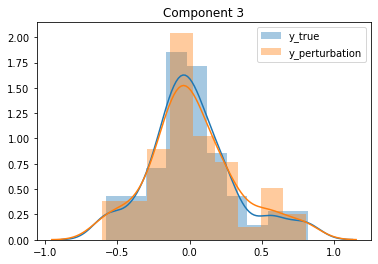

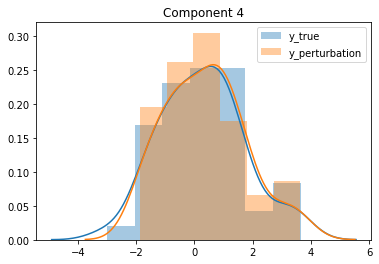

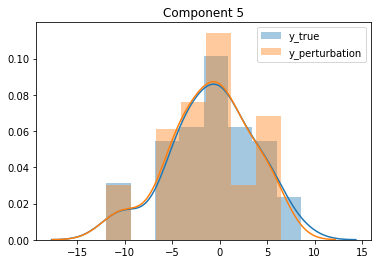

In [4]:
y_true, W_star, Z_star, sigma2_star, v_star_list = forward_sample(
    d, q_star, n_sample, prior_param_true, verbose=True)
y_perturbation = sample_perturbation2(y_true, n_sample, alpha)
#y_perturbation = forward_sample(d, q_star, n_sample, prior_param_true, verbose = True)

for j in range(d):
    sns.distplot(y_true[j, :], label='y_true')
    sns.distplot(y_perturbation[j, :], label='y_perturbation')
    plt.legend()
    plt.title('Component ' + str(j+1))
    plt.show()

In [5]:
X = y_true

## 2. MCMC Prior

In [6]:
config = configparser.ConfigParser()
config.sections()
# for i in os.listdir('param2/'):
config.read("10000.ini")
mcmc_setup = dict(config['mcmc_setup'])

In [7]:
# inference parameter
d = int(data_config['d'])
q = int(mcmc_setup['q'])
xi = float(mcmc_setup['xi'])


# prior parameter
beta_sigma2 = float(mcmc_setup['beta_sigma2'])
a_sigma2 = float(mcmc_setup['a_sigma2'])
a_vj = float(mcmc_setup['a_vj']) * np.ones(q)
beta_vj = float(mcmc_setup['beta_vj']) * np.ones(q)
epsilon = float(mcmc_setup['epsilon'])
#beta_vj = epsilon * (a_vj - 1)


# sampling parameter
prior_param_mcmc = dict({'beta_sigma2': beta_sigma2,
                         'a_sigma2': a_sigma2,
                         #'a_vj': a_vj,
                         #'beta_vj': beta_vj
                         'a_vj': 0.5,
                         'beta_vj': 0.01
                         })

In [8]:
prior_param_mcmc

{'beta_sigma2': 0.02, 'a_sigma2': 3.0, 'a_vj': 0.5, 'beta_vj': 0.01}

In [9]:
n_chains = int(mcmc_setup['n_chains'])
iterations = int(mcmc_setup['iterations'])

## 3. MCMC Gibbs

In [10]:
mcmc_list = []
for sub_chains in range(n_chains):
    init_dict = dict({'Z0': np.random.normal(0, 1, [q, n_sample]),
                      "sigma20": sigma2_star,
                      # "w0": W_star,
                      'w0': np.random.normal(0, 1, [d, q]),
                      # 'v0': np.repeat(v_star_list, q).ravel(),
                       'v0': np.array(sorted(v_star_list))})
                      #'v0': sorted(1/np.random.gamma(a_vj, 1 / beta_vj))})

    inference = Model(X, init_dict, iterations, q, prior_param_mcmc, xi=1)
    mcmc_list.append(inference.gibbs_result())

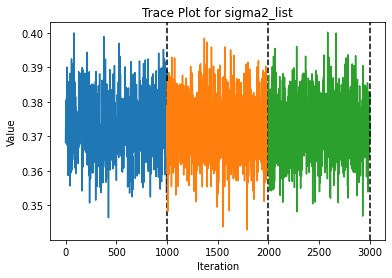

In [11]:
var_list = ['sigma2_list']
trace_plot(mcmc_list, var_list)

In [12]:
print(sigma2_star)

0.3742285731207119


In [13]:
sigma2_list = get_trace_list(mcmc_list, 'sigma2_list')
Z_list = get_trace_list(mcmc_list, 'Z_list')
W_list = get_trace_list(mcmc_list, 'W_list')
v_list = get_trace_list(mcmc_list, 'v_list')

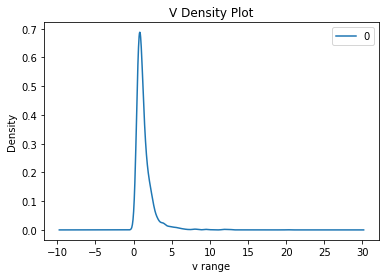

In [14]:
v_table = plot_v_density(v_list)

In [15]:
np.mean(v_list, axis=1)

array([[1.40792228],
       [1.36765666],
       [1.3848506 ]])

In [16]:
print(v_star_list)

[0.8714235]


## 4. MCMC Pystan Ordered $V_j$

In [17]:
init_list = []
for i_ in range(n_chains):
    temp_dict = {
         'v': np.repeat(v_star_list, q).ravel(),
#         'v': sorted(v_star_list),
#        'v': sorted(1/np.random.gamma(a_vj, 1 / beta_vj)),
        'sigma2': sigma2_star,
#         "W": W_star.T
        'W': np.repeat(W_star, q).reshape([q,d])

    }
    init_list.append(temp_dict)

In [18]:
sm = pystan.StanModel(model_code=ppca_code)  # code compile

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_63301508e4b0b251ee904fb50f07455e NOW.


In [19]:
print(sm.model_code)


data { 
    int D; //number of dimensions
    int N; //number of data
    int Q; //number of principle components
//    matrix[N,D] x; // data
    vector[D] x[N]; //data
    real a_vj; // w_j prior 
//    real epsilon;// w_j mean
    real beta_vj; //w_j prior
    real xi; // power parameter
    real a_sigma2; // sigma2 prior 
    real beta_sigma2;// sigma2 mean
 //   vector[Q] v; // true v_j
}

transformed data {
    matrix[D,D] S;
    S = x[1] * x[1]';
    
    for (n in 2:N){
    S += x[n] * x[n]';
    }
    S = S/N;
    
}
parameters {
//    vector[Q] v; // v_j
    ordered[Q] v; // v_j
    real<lower=0> sigma2; //data sigma2
    matrix[Q,D] W; //projection matrix
}
model {
    matrix[D,D] C; //covaraince matrix
    for(j in 1:Q){
//        v[j] ~ inv_gamma(a_vj, epsilon * (a_vj -1));
        v[j] ~ inv_gamma(a_vj, beta_vj);
        W[j] ~ multi_normal(rep_vector(0,D), v[j] * diag_matrix(rep_vector(1, D)));
        }
        
    sigma2 ~ inv_gamma(a_sigma2, beta_sigma2);
    
    C

In [20]:
ppca_dat_standard = {'D': d,
                     'N': n_sample,
                     'Q': q,
                     'x': X.reshape([n_sample, d]),
                     'xi': 1,
                     'a_vj': a_vj[0],
#                     'epsilon': epsilon,
                     'beta_vj': beta_vj[0],
                     'a_sigma2': a_sigma2,
                     'beta_sigma2': beta_sigma2,
#                     'v': v_star_list
#                      'v': np.repeat (v_star_list,q)
                     }

In [21]:
control = {}
control['max_treedepth'] = 20
control['adapt_delta'] = 0.99

In [22]:
fit_standard = sm.sampling(data=ppca_dat_standard,
                           iter=iterations, chains=n_chains, init=init_list, control=control)
#fit_standard = sm.sampling(data=ppca_dat_standard,
#                           iter=iterations, chains=n_chains, init=init_list)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
sigma2  1.403  0.032   1.345    1.467      0.001    0.001     986.0   983.0   
v[0]    0.097  0.090   0.009    0.245      0.007    0.005     183.0   177.0   
W[0,0]  0.291  0.189  -0.109    0.591      0.052    0.037      13.0    13.0   
W[0,1] -0.220  0.143  -0.445    0.142      0.040    0.029      13.0    13.0   
W[0,2] -0.210  0.136  -0.401    0.163      0.038    0.027      13.0    13.0   
W[0,3]  0.140  0.131  -0.113    0.377      0.026    0.018      26.0    26.0   
W[0,4]  0.158  0.124  -0.093    0.395      0.031    0.022      16.0    16.0   

        ess_bulk  ess_tail  r_hat  
sigma2    1002.0    1104.0   1.00  
v[0]       361.0     239.0   1.00  
W[0,0]      40.0      12.0   1.07  
W[0,1]      33.0      11.0   1.06  
W[0,2]      34.0      11.0   1.06  
W[0,3]      40.0      18.0   1.05  
W[0,4]      33.0      13.0   1.06  


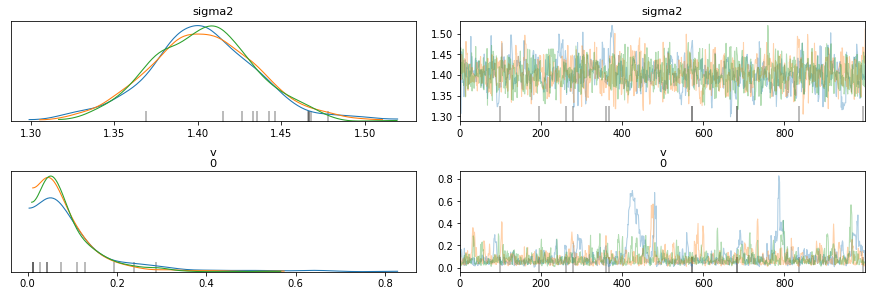

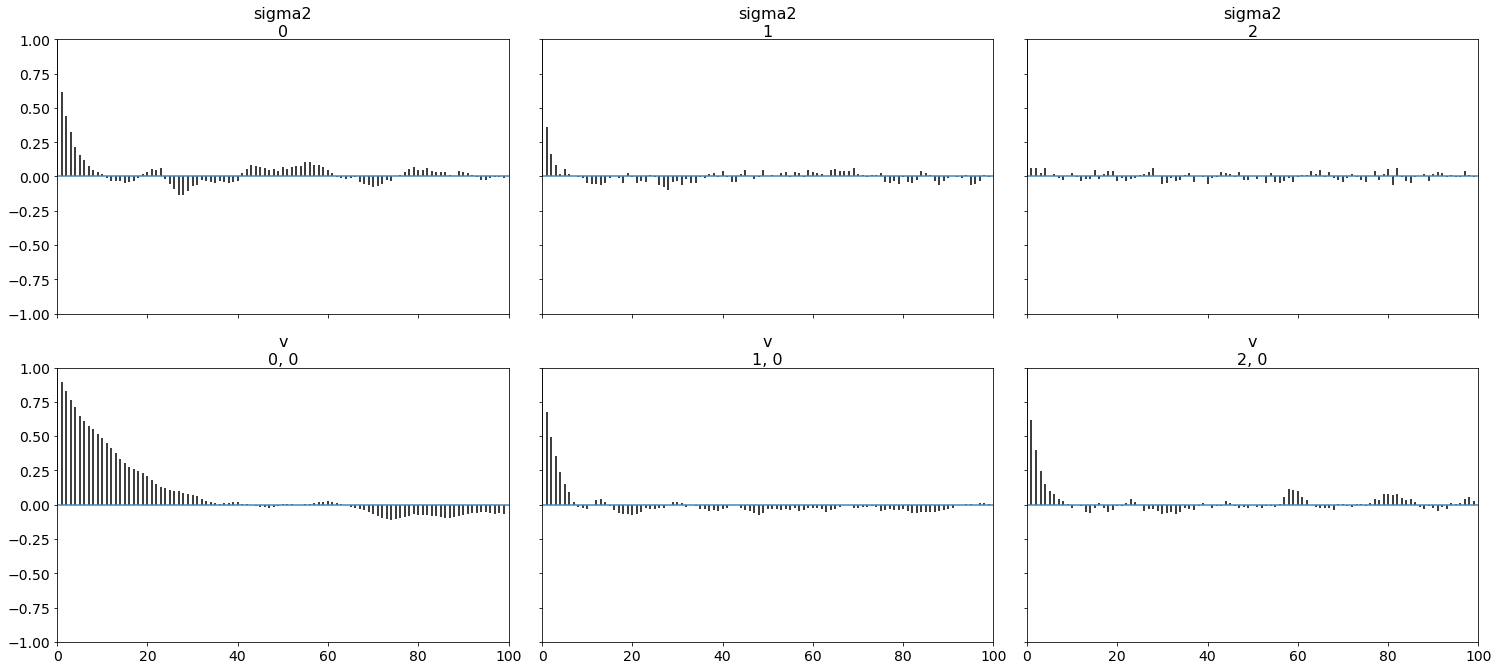

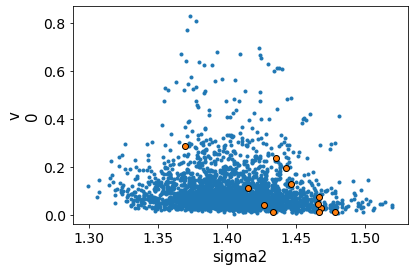

In [23]:
az_v_sigma2_plot(fit_standard, ['sigma2','v'])

In [24]:
print(v_star_list)

[0.8714235]


In [25]:
sigma2_star

0.3742285731207119

In [26]:
para_star = np.append(v_star_list, np.append(sigma2_star, W_star.T))

In [27]:
para_stan = np.append(np.mean(fit_standard.extract('v')['v']), np.append(np.mean(fit_standard.extract('sigma2')['sigma2']), np.mean(fit_standard.extract('W')['W'],axis=0)))

In [28]:
para_init =  np.append(fit_standard.get_inits()[0]['v'],  np.append(fit_standard.get_inits()[0]['sigma2'], fit_standard.get_inits()[0]['W']))

In [29]:
print('True Param: '+ str(para_star))
print('Stan Param: '+ str(para_stan))
print('Initial Param: '+ str(para_init))

True Param: [ 0.8714235   0.37422857  1.0269546  -1.06554339 -0.82764188  1.61063515
 -0.44701642]
Stan Param: [ 0.09713582  1.40328457  0.29120923 -0.22037535 -0.21001912  0.14013084
  0.15777963]
Initial Param: [ 0.8714235   0.37422857  1.0269546  -1.06554339 -0.82764188  1.61063515
 -0.44701642]


In [30]:
fit_standard.log_prob(para_star)

-3816.6367454724923

In [31]:
fit_standard.log_prob(para_stan)

-4423.422431424489

In [32]:
fit_standard.log_prob(para_init)

-3816.6367454724923

In [33]:
#fit_standard = sm.optimizing(data=ppca_dat_standard,init=init_list)

## 5. MCMC Pystan Exact Sampling

In [34]:
ppca_dat_standard = {'D': d,
                     'N': n_sample,
                     'Q': q,
                     'x': X.reshape([n_sample, d]),
                     'xi': xi,
                     'a_vj': a_vj[0],
#                     'epsilon': epsilon,
                     'beta_vj': beta_vj[0],
                     'a_sigma2': a_sigma2,
                     'beta_sigma2': beta_sigma2,
#                     'v': v_star_list
#                      'v': np.repeat (v_star_list,q)
                     }

In [35]:
fit_exact = sm.sampling(data=ppca_dat_standard,
                           iter=iterations, chains=n_chains, init=init_list, control = control)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
sigma2  1.427  0.048   1.344    1.522      0.002    0.001     853.0   850.0   
v[0]    0.063  0.073   0.002    0.173      0.005    0.004     209.0   152.0   
W[0,0]  0.026  0.263  -0.447    0.457      0.014    0.010     357.0   357.0   
W[0,1] -0.019  0.200  -0.353    0.353      0.011    0.008     322.0   322.0   
W[0,2] -0.017  0.194  -0.359    0.328      0.010    0.007     342.0   342.0   
W[0,3]  0.012  0.177  -0.313    0.344      0.008    0.006     466.0   466.0   
W[0,4]  0.012  0.172  -0.291    0.329      0.009    0.006     357.0   357.0   

        ess_bulk  ess_tail  r_hat  
sigma2     862.0    1442.0    1.0  
v[0]       427.0     258.0    1.0  
W[0,0]     383.0    1233.0    1.0  
W[0,1]     343.0    1491.0    1.0  
W[0,2]     363.0    1169.0    1.0  
W[0,3]     467.0    1134.0    1.0  
W[0,4]     373.0    1290.0    1.0  


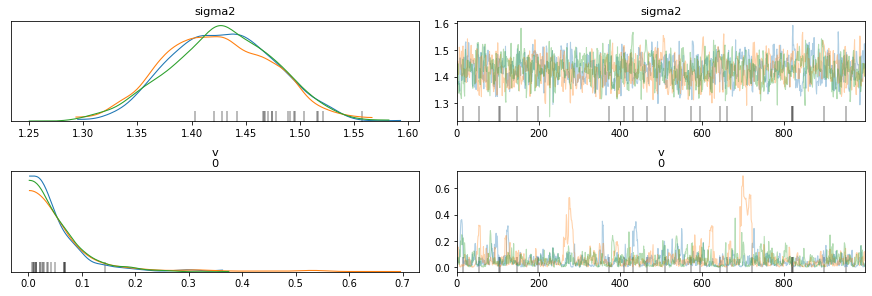

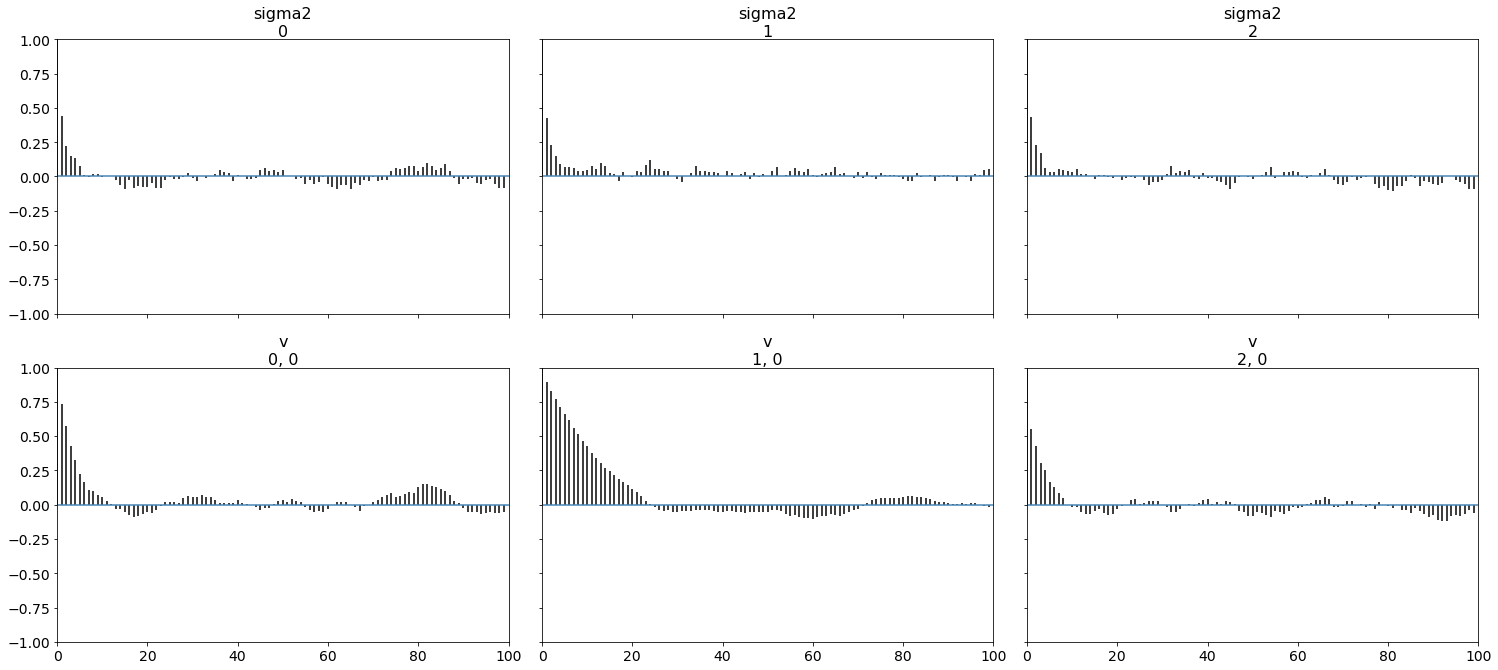

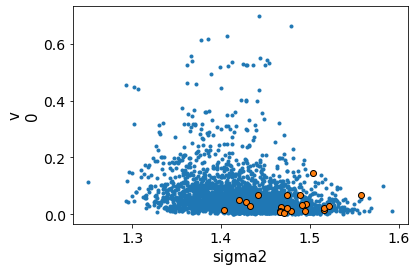

In [36]:
az_v_sigma2_plot(fit_exact, ['sigma2','v'])

In [37]:
para_star = np.append(v_star_list, np.append(sigma2_star, W_star.T))
para_stan = np.append(np.mean(fit_exact.extract('v')['v']), np.append(np.mean(fit_exact.extract('sigma2')['sigma2']), np.mean(fit_exact.extract('W')['W'],axis=0)))
para_init =  np.append(fit_exact.get_inits()[0]['v'],  np.append(fit_exact.get_inits()[0]['sigma2'], fit_exact.get_inits()[0]['W']))

In [38]:
fit_exact.log_prob(para_star)

-1910.2571956996217

In [39]:
fit_exact.log_prob(para_stan)

-2219.0111715181934

In [40]:
fit_exact.log_prob(para_init)

-1910.2571956996217

In [41]:
v_range = np.linspace(0.1, 2, 1000) 
sigma2_range = np.linspace(0.1, 2, 1000)
log_prob_v = []
log_prob_sigma2=[]
for v in v_range:
    para_try = np.append([v], np.append(sigma2_star, W_star.T))
    log_prob_v.append(fit_exact.log_prob(para_try))
    

for sigma2 in sigma2_range:
    
    para_try2 = np.append(v_star_list, np.append([sigma2], W_star.T))
    log_prob_sigma2.append(fit_exact.log_prob(para_try2))    

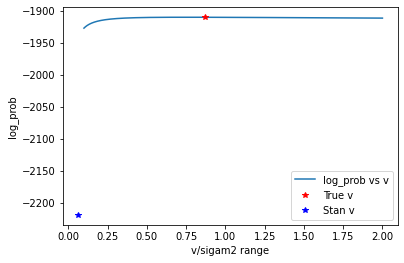

In [45]:
#plt.plot(sigma2_range, log_prob_sigma2, label ='log_prob vs sigma2')
plt.plot(v_range, log_prob_v, label ='log_prob vs v')

plt.xlabel('v/sigam2 range')
plt.ylabel('log_prob')
plt.plot(v_star_list, fit_exact.log_prob(para_star), 'r*', label = 'True v')
#plt.plot(para_stan[0], fit_exact.log_prob(para_stan), 'b*', label = 'Stan v')
plt.legend()

In [43]:
v_list = get_trace_list([fit_exact], 'v')

In [44]:
para_stan

array([ 0.06255989,  1.42722427,  0.0264015 , -0.01889347, -0.01703266,
        0.01164121,  0.01158563])